<a href="https://colab.research.google.com/github/jamesafful/classprojects/blob/main/James_Afful_F2023_HW3_FCNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AFFUL, James, 490378933


Use the form of Last Name, First Name, ISU student ID: (Example) DICKERSON, JULIE, 123456789


# HW 3: CIFAR-10 Classification: PyTorch Implementation

In this assignment, you will be classifying the contents of the ten types of images in the CIFAR10 dataset. The implementation will be in PyTorch.

THe learning objectives of the assignment are:

    Learn to use the PyTorch ML framework for creating and training deep networks.
    Learn a structured approach to setting up models, training and testing.
    Experiment with and explain different types of regularization in training networks.

In the last section of the assignment, there are questions that you need to answer about model performance and the concepts for characterizing performance. You may answer the questions in the run notebook that you submit or in a separate pdf document. Since much of the model has been created for you, most of the points in the project will come from your answers.

This notebook was beautifully created by TA Mr. Samuel Fanijo with comments and text by Dr. Julie A Dickerson at Iowa State University. 2023.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
# if you have not installed torchvision or it is missing your installation, need to run the following line
!pip3 install torchvision
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random

In [ ]:
# Define device (GPU if available, else CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])


## 1.  Function to get training, validation, and test datasets
This function uses the built-in torchvision datasets that includes many of the standard datasets used to compare networks. Please see <a href="<a href="https://pytorch.org/vision/main/datasets.html" target="_blank" rel="noopener">Torchvision Datasets</a> for more information.
    
Data transformations transform and normalize the data for your network.



In [ ]:
# Function to get training, validation, and test datasets
def get_datasets(transform, batch_size):
    """
    Loads the CIFAR-10 dataset, applies transformations, and splits it into training, validation, and test sets.

    Args:
    - transform: PyTorch transformation to apply to the data.

    Returns:
    - trainloader: DataLoader for the training set.
    - valloader: DataLoader for the validation set.
    - testloader: DataLoader for the test set.
    """
    # Load CIFAR-10 dataset
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Split the training dataset into training and validation
    num_train = len(trainset)
    indices = list(range(num_train))
    split = int(np.floor(0.2 * num_train))

    np.random.seed(42)
    np.random.shuffle(indices)

    train_idx, val_idx = indices[split:], indices[:split]
    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_idx)

    # Create data loaders for training, validation, and test
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
    valloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=val_sampler)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainloader, valloader, testloader


In [ ]:
# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## 2. Define neural network model
The model set up here is an initial model with three layers. The input layer is size [3072, 512], the hidden layer is [512,256] and the output layer is [256,10]. The activations for the input and hidden layers are the relu function and the output activation will be a softmax function with the cross-entropy loss.

The *init* function defines the layers. The *forward* function defines the forward pass. Note that we are not explicitly adding the softmax function in the output layer. We will instead used the defined function cross-entropy loss that implements both the softmax and the cross-entropy loss.

I strongly suggest that you look at the documentation for the *nn* package in PyTorch to understand the layer types.

In [ ]:
# Define fully connected neural network model
class FCNet(nn.Module):
    """
    A fully connected neural network model for image classification on the CIFAR-10 dataset.

    Architecture:
    - Input: Flattened feature vectors of size 3*32*32
    - Fully Connected Layer 1: 3*32*32 to 512 neurons with ReLU activation
    - Fully Connected Layer 2: 512 to 256 neurons with ReLU activation
    - Fully Connected Layer 3: 256 to 10 output neurons (for 10 classes)

    This network is designed for image classification task with the input data as
    flattened feature vectors. It uses densely connected layers (fully connected layers)
    with ReLU activations to learn the spatial features and relationships in the data.

    Attributes:
    - fc1: First fully connected layer.
    - fc2: Second fully connected layer.
    - fc3: Output layer with 10 classes for CIFAR-10.

    Methods:
    - forward(x): Defines the forward pass of the network.
    """

    def __init__(self):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)  # Input size 3*32*32, output size 512
        self.fc2 = nn.Linear(512, 256)  # Hidden layer with 256 neurons
        self.fc3 = nn.Linear(256, 10)  # Output layer with 10 classes

    def forward(self, x):
        """
        Defines the forward pass of the fully connected neural network.

        Args:
        - x: Input feature vector (flattened image).

        Returns:
        - x: Output tensor representing class scores.
        """
        x = x.view(-1, 3 * 32 * 32)  # Flatten the input tensor into a vector
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to the first layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation to the second layer
        x = self.fc3(x)  # Output layer
        return x


## 3. Function to train the neural network using training set
The functions below use the data loader capabilities to train your network and check the validation and testing data against your trained network. You will not have to make any changes to this function but you should be able to explain how it works.

In [ ]:
# Function to train the neural network using training set
def train_model(model, trainloader, optimizer, criterion, device):
    """
    Trains the neural network on the training dataset.

    Args:
    - model: PyTorch neural network model.
    - trainloader: DataLoader for the training set.
    - optimizer: PyTorch optimizer.
    - criterion: Loss function.
    - device: Device to run the training on (CPU or GPU).

    Returns:
    - train_loss: Average training loss for the epoch.
    - train_accuracy: Training accuracy for the epoch.
    """
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients to avoid accumulation

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the model parameters

        running_loss += loss.item()  # Accumulate the loss

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train

    return running_loss / len(trainloader), train_accuracy

### Function to validate the neural network using validation set

In [ ]:
# Function to validate the neural network using validation set
def validate_model(model, valloader, device):
    """
    Validates the neural network on the validation dataset.

    Args:
    - model: PyTorch neural network model.
    - valloader: DataLoader for the validation set.
    - device: Device to run the validation on (CPU or GPU).

    Returns:
    - val_accuracy: Validation accuracy.
    """
    model.eval()  # Set the model to evaluation mode
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val

    return val_accuracy


### Function to test the model using test set

In [ ]:
# Function to test the neural network using test set
def test_model(model, testloader, device):
    """
    Tests the trained neural network on the test dataset.

    Args:
    - model: PyTorch neural network model.
    - testloader: DataLoader for the test set.
    - device: Device to run the testing on (CPU or GPU).

    Returns:
    - test_accuracy: Test accuracy.
    - true_labels: True labels of test samples.
    - predicted_labels: Predicted labels by the model.
    """
    model.eval()
    correct_test = 0
    total_test = 0
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    test_accuracy = 100 * correct_test / total_test

    return test_accuracy, true_labels, predicted_labels

## 4. Define optimizer
In this function, you will need to select which optimizer to use. We have given you 2 different examples. PyTorch has multiple optimizers defined in the [torch.optim](/https://pytorch.org/docs/stable/optim.html) package. You will need to implement two different options from the extensive list of functions and discuss the results

In [ ]:
# Function to select an optimizer
def select_optimizer(optimizer_option, model):
    """
    Define an optimizer for training.

    Returns:
    - optimizer: PyTorch optimizer.
    """
    if optimizer_option == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_option == 'momentum':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif optimizer_option == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    else:
        raise ValueError("Invalid optimizer option")

    return optimizer

### 5. Main: putting everything together
When you run this block, it will ask you to enter in the batch size (try 32, 64 or 128) and which optimizer to use at the bottom (this is hard-coded and you will replace the value). You can also set the number of epochs to train over in the main function.

Select optimizer option (adam,  momentum, SGD): adam
Enter batch size: 128
Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.6556614142256423, Training Accuracy: 41.425%, Validation Accuracy: 45.63%
Epoch 2, Loss: 1.4362516437475674, Training Accuracy: 49.29%, Validation Accuracy: 49.42%
Epoch 3, Loss: 1.3156463947539894, Training Accuracy: 53.8075%, Validation Accuracy: 51.03%
Epoch 4, Loss: 1.2123800285708028, Training Accuracy: 57.145%, Validation Accuracy: 52.26%
Epoch 5, Loss: 1.128269821500626, Training Accuracy: 60.105%, Validation Accuracy: 53.26%
Epoch 6, Loss: 1.031600366194789, Training Accuracy: 63.4825%, Validation Accuracy: 53.25%
Epoch 7, Loss: 0.9475638161832913, Training Accuracy: 66.52%, Validation Accuracy: 51.54%
Epoch 8, Loss: 0.8601297684751761, Training Accuracy: 69.4675%, Validation Accuracy: 52.8%
Epoch 9, Loss: 0.7842201470567015, Training Accuracy: 72.1425%, Validation Accuracy: 53.38%
Epoch 10, Loss: 0.7055286707969

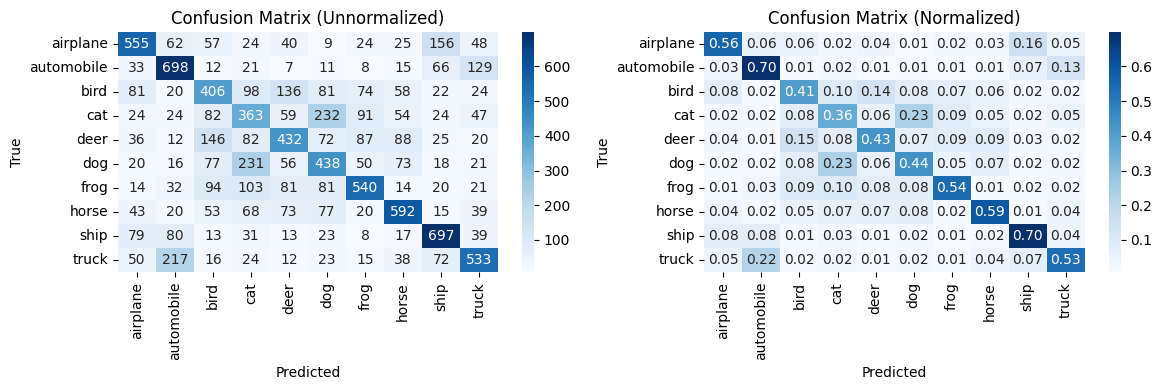


Randomly Select 10 Samples for Testing:


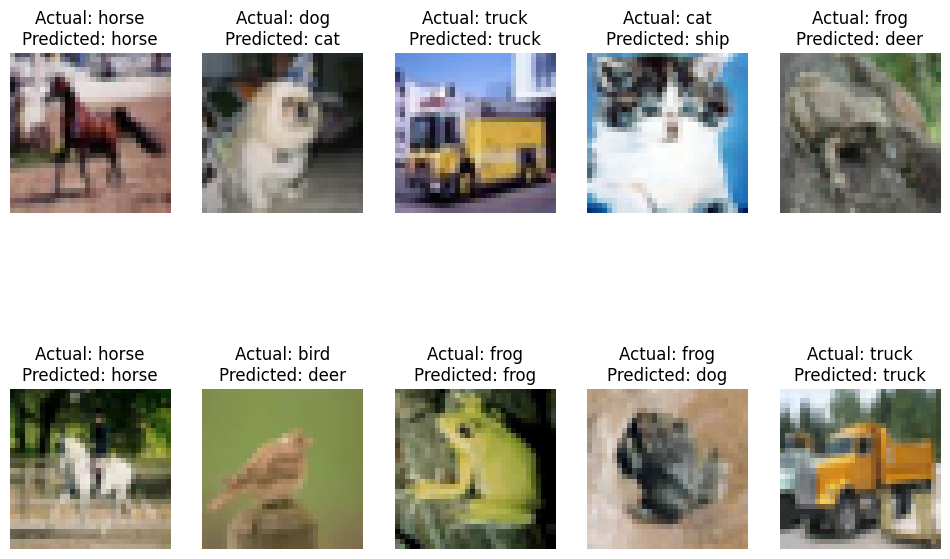

In [ ]:
# Main function to run the deep learning pipeline
def main(optimizer_option, batch_size):
    """
    Main function to run the model with specified optimizer.

    Args:
    - optimizer_option (may or may not be hardcoded)
    - batch size for training.
    """

    ##################### Define run parameters #########################################
    # Get datasets
    trainloader, valloader, testloader = get_datasets(transform, batch_size)

    # Initialize the model
    model = FCNet().to(device)

    #model = CNNNet().to(device)

    # Select optimizer based on user's choice
    optimizer = select_optimizer(optimizer_option, model)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Lists to store training and validation accuracy
    train_accuracy_list = []
    val_accuracy_list = []

    # Set Number of epochs to train model for
    num_epochs = 15

    ####################################################################################


    # Train the model for multiple epochs
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_model(model, trainloader, optimizer, criterion, device)
        val_accuracy = validate_model(model, valloader, device)

        # Append accuracy values to lists for later plotting
        train_accuracy_list.append(train_accuracy)
        val_accuracy_list.append(val_accuracy)

        print(f'Epoch {epoch + 1}, Loss: {train_loss}, Training Accuracy: {train_accuracy}%, Validation Accuracy: {val_accuracy}%')

    print('Finished Training')

    # Test the model
    test_accuracy, true_labels, predicted_labels = test_model(model, testloader, device)

    print(f'Test Accuracy: {test_accuracy}%')

    # Calculate classification report
    print(classification_report(true_labels, predicted_labels, target_names=class_names))

    # Create confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Plot unnormalized confusion matrix
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Unnormalized)')

    # Plot normalized confusion matrix
    normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    plt.subplot(1, 2, 2)
    sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Normalized)')
    plt.tight_layout()
    plt.show()

    # Randomly select 10 samples for testing
    print("")
    print("Randomly Select 10 Samples for Testing:")
    random_indices = random.sample(range(len(testloader.dataset)), 10)
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(random_indices):
        plt.subplot(2, 5, i + 1)
        image, label = testloader.dataset[idx]
        image = image / 2 + 0.5  # Unnormalize
        np_image = image.numpy()
        plt.imshow(np.transpose(np_image, (1, 2, 0)))
        actual_label = class_names[label]
        predicted_label = class_names[predicted_labels[idx]]
        plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
        plt.axis('off')
    plt.show()

if __name__ == "__main__":
    # Select the optimizer option
    optimizer_option = input("Select optimizer option (adam,  momentum, SGD): ")

    #optimizer_option = "SGD" #changed to an hardcoded version

    # Select the batch size for training
    batch_size = int(input("Enter batch size: "))
    main(optimizer_option, batch_size)

My best Test accuracy was 54.37%

## 6 Questions and exercises

### 6.1 Exercises (40 points)

E1. Using the original file and variables, discuss the overall results of the training. Overall, the system did not do well with an accuracy of just over 50% and the confusion matrices given above. In what situations did the system perform poorly or better? Is the system overfit or underfit? Give two approaches that might help improve system performance based on the results.

**Answer**: With the approaches that might help improve system performance based on the results, I think we can first complexify/modify the network architecture.  The current architecture is a simple fully connected network. Convolutional Neural Networks (CNNs) are more suitable for image data like CIFAR-10, as they can capture spatial hierarchies in images which simple dense layers might not capture. Secondly, we could try some data augmentation techniques.By applying small transformations like rotations, translations, zooming, etc., to the training images, data augmentation artificially increases the size of the training set, helping the model generalize better. This, I think, often prevents overfitting and can boost performance. I can use the transforms variable in the code to achieve this. We could also try L2 regularization in order to prevent overfitting.
The system performed better with increased batch size; faster training per epoch, but started encountering memory issues at higher batch sizes. With increased epochs, there was better training performance, and I think there was a risk of overfitting, and lastly there was a plataeu of acccuracy of the model.
*************************************




E2. Implement one of your approaches in the code. Be sure to highlight what you did and describe it in words in this section. (you can change models, learning rates, optimization, add in regularization, train for different times,etc.) Comment on **why** you made each change. Give the setup that gave you the **best** results in your Python Notebook file with the run results saved.

**Answer:**



**Approach:** Data Augmentation.

**Why?** By applying various operations on the images, like rotation, cropping, flipping, etc variability is introduced, and this helps in reducing overfitting since the model gets exposed to various versions of the same image.

In [ ]:
# 1st tried data augmentation/transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


**Comments:** This made the model perform poorly

Random Horizontal Flip: This transformation randomly flips the image horizontally.

Random Crop with Padding: This transformation first pads the image and then takes a random crop of the original size. This results in slight zoomed-in versions of the original image.

Color Jitter: This transformation randomly changes the brightness, contrast, and saturation of the image. This ensures the model is robust to slight variations in lighting and color.

Random Rotation: The images are randomly rotated by a degree (here 10). This ensures the model becomes invariant to slight rotations of objects.

**Approach:** Introduce Convolutional Neural Network (CNN) layers.

**Why?** I think CNNs  can capture spatial hierarchies of patterns in images by applying convolutional filters, pooling layers, and fully connected layers. This makes them very effective for tasks like image classification.

In [ ]:
# I also tried using a deeper convolutional neural network in the architecture, but had some errors in my implementation.
#I resolved the issue by adding the first two lines of code below

import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the new CNN architecture
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 500)  # Assuming pooling is done twice, each reducing size by half, image size becomes 32 -> 16 -> 8 -> 4
        self.fc2 = nn.Linear(500, 10)
        # Dropout layer
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # Apply convolutional layers with ReLU and MaxPooling
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        # Flatten the tensor
        x = x.view(-1, 64 * 4 * 4)
        # Apply fully connected layers with ReLU
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x



**Comments:** Saw slight improvements in my model.

Convolutional Layers: Added three convolutional layers, which help in feature extraction. As we move deeper into the network, the number of channels (or filters) increases, allowing the model to detect more complex features.

Pooling Layers: After each convolutional layer, I applied max-pooling which reduces the spatial dimensions of the output by half. This reduced the number of parameters, helped in capturing the most important features, and reduced the chances of overfitting.

Fully Connected Layers: After the convolutional layers, we added two fully connected layers to make the final classification based on the extracted features.

Dropout for Regularization: We've added a dropout layer to regularize the network and reduce the potential of overfitting.
*************************************




E3. Compare the difference in the results obtained from two different optimizers. when might you choose one over the other, and why?

**Adam:**
Adam tends to converge faster than SGD since it uses both momentum (moving average of the gradients) and adaptive learning rates (moving average of the squared gradients). I think in some cases, during the initial epochs, Adam might outperform SGD because of its property of adjusting learning rates for each parameter based on the historical gradient data. Adam uses more memory compared to standard SGD.

**SGD**
SGD, even with momentum, might converge slower than Adam. However, the momentum term can help overcome local minima and saddle points, speeding up convergence.

**Decision:**
I think for quick results, Adam could be a better choice due to its faster convergence, especially in the early epochs. However, for the best final performance, especially on large datasets, SGD might be the way to go, even though it would require careful tuning of hyperparameters. For concerns about memory, like in my case, running either on my local pc or colab, using Adam might be a challenge because of the additional memory overhead, so SGD is preferred.
**********************************

### 6.2 Conceptual Questions: (10 Points)

C1. A “loss landscape” of your neural network’s loss function has a plateau shape, in
which there are large areas where the loss is flat. This means the gradient signal will be weak and gradient descent will not update the network parameters very much in each iteration.

What are two activation functions that may cause such a problem, and one activation function that will not?

**Answer:**

A "plateau" shape in the loss landscape indicates regions of vanishing gradients, where the gradients are close to zero.

1. **Activation functions that can cause vanishing gradients**:
   
   - **Sigmoid (Logistic Activation Function)**:
     - The sigmoid function squashes its input into the range [0, 1]. For inputs with large absolute values (either large positive or large negative), the gradients of the sigmoid function are close to zero. Therefore, during backpropagation, the gradient values can vanish, especially when multiple layers are involved.
     
   - **Hyperbolic Tangent (tanh)**:
     - The tanh function is similar to the sigmoid but squeezes its input into the range [-1, 1]. Just like the sigmoid, the tanh function can have vanishing gradients for large absolute value inputs.

2. **Activation function less likely to cause vanishing gradients**:

   - **Rectified Linear Unit (ReLU)**:
     - ReLU helps mitigate the vanishing gradient problem. For any positive input, its gradient is 1, and for non-positive inputs, its gradient is 0. This means that for a significant portion of its domain (all positive values), the gradient does not vanish.




********************************************
C2. Which methods may help accelerate the optimization of a model that uses batch gradient descent?
a. Using Adam.
b. Fine tuning the learning rate using grid search.
c. Initializing all the weights to zero.
d. Using mini-batch gradient descent.

**Answer:**
- **Using Adam:**
True. Adam combines the advantages of two other extensions of stochastic gradient descent: AdaGrad and RMSProp. Adam computes adaptive learning rates for each parameter and keeps an exponentially decaying average of past gradients. This helps in faster convergence and can lead to better performance in practice compared to basic batch gradient descent.

**Fine tuning the learning rate using grid search:**
True. The learning rate is a critical hyperparameter for the convergence of the optimization algorithm. Too high a learning rate can cause divergence, and too low a learning rate can cause the training process to be very slow. Fine-tuning the learning rate can help in finding an optimal value that results in faster and more stable convergence.


**Initializing all the weights to zero:**
False. Initializing all the weights to zero is a bad idea, especially for deep networks. When all weights are initialized to zero, every neuron in the network computes the same output and backpropagation will update all of the weights by the same amount. This makes the network symmetric, and different neurons fail to learn different features.

**Using mini-batch gradient descent:**
True. Mini-batch gradient descent combines the advantages of both stochastic gradient descent and batch gradient descent. Instead of using the entire dataset (as in batch gradient descent) or just one example (as in stochastic gradient descent), it uses a mini-batch of samples. This helps in achieving faster convergence by approximating the gradient of the entire dataset and also adding some level of noise to escape local minima.

So, **the correct answers are a, b, and d**.



****************************************


C3. Compute the value of the function f(θ)=(θ-1)^4 after updating θ in one step of gradient descent, for θ = 4 and η=0.01. Does it look like the algorithm will converge to an optimum value of the function? Why or why not?

**Answer:**
Given θ = 4
f'(4) = 4(4-1)^3 = 4(3^3) = 4(27) = 108

θnew = 4-0.01 x 108 = 4-1.08 = 2.92

f(2.92)=(2.92−1)^4 ≈ 13.59


Now, regarding convergence to an optimum:

The function is a fourth-degree polynomial that has a global minimum at θ = 1. Our initial θ value was 4, and after one iteration of gradient descent, it got updated to 2.92, which is closer to the global minimum at 1. Given that the value of θ is moving in the right direction, and considering the nature of the function, it seems like gradient descent will eventually converge to the optimum value (or very close to it), given a sufficiently large number of iterations and an appropriate learning rate. Due to the plateau shape around the minimum, I anticipate that gradient descent might become slow as it approaches the minimum, especially with a small learning rate.



***********************************
C4. Which statements are true about the step size in gradient descent?
a. The step size is the learning rate times the magnitude of the gradient.
b. If the step size is too big, gradient descent may oscillate leading to slow or unstable convergence.
c. The smaller the step size, the faster we can reach the optimal minima.

**Answer:**

a. The step size is the learning rate times the magnitude of the gradient.
   - **True.** The step size, or the amount by which we update our parameters, is indeed the product of the learning rate and the gradient.

b. If the step size is too big, gradient descent may oscillate leading to slow or unstable convergence.
   - **True.** A large step size (due to a large learning rate) can cause the algorithm to "overshoot" the minimum and bounce back and forth on either side of the valley, leading to oscillations. This can cause slow convergence, or in some cases, divergence where the algorithm fails to find the minimum.

c. The smaller the step size, the faster we can reach the optimal minima.
   - **False.** A smaller step size means we're making smaller updates to our parameters in each iteration. This can lead to very slow convergence towards the optimal minima. While it might help in terms of precision, it can be computationally expensive and inefficient. If the step size is too small, the algorithm might get stuck or take an impractically long time to converge.

**So, the correct statements are: a and b.**


****************************************
C5. State if each statement is true or false and give a brief reason

A). L2 regularization encourages sparse weights.

B) You notice that while training your neural network the test loss initially decreases
but then starts increasing, while training loss continues to decrease. This means
that test loss will only continue to increase if we train further.

**Answer:**
A) L2 regularization encourages sparse weights.
   - **False.** L2 regularization (also known as Ridge regularization) discourages large weights by adding a penalty term proportional to the square of the magnitude of weights to the loss function. However, it does not encourage sparsity in the weight matrix. Lasso regularization adds a penalty proportional to the absolute value of weights, and this does encourage sparse weights, i.e., leading to many weights becoming zero (0).

B) You notice that while training your neural network the test loss initially decreases but then starts increasing, while training loss continues to decrease. This means that test loss will only continue to increase if we train further.
   - **False.** While an increasing test loss and a decreasing training loss suggest that the model is overfitting to the training data, it doesn't guarantee that test loss will only continue to increase if we train further. There could be oscillations or plateaus. However, it is a strong indication that the model has started to fit the training data too closely, capturing noise and not generalizing well to new, unseen data. If this pattern persists for a significant number of epochs, it is likely beneficial to stop training to prevent further overfitting.



*****************************************